In [2]:
import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent.parent))  # add repo root

from pathlib import Path
import json
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cm

import networkx as nx
from ndtools.graphs import build_graph


## Load data


In [3]:
DATASET = Path("data") 

nodes = json.loads((DATASET / "nodes.json").read_text(encoding="utf-8"))
edges = json.loads((DATASET / "edges.json").read_text(encoding="utf-8"))
probs_dict = json.loads((DATASET / "probs_eq.json").read_text(encoding="utf-8"))
cond_sys_probs_dict = json.loads((DATASET / "cond_sys_probs.json").read_text(encoding="utf-8"))
sys_probs_dict = json.loads((DATASET / "sys_probs.json").read_text(encoding="utf-8"))
robustness_indices_dict = json.loads((DATASET / "robustness_indices.json").read_text(encoding="utf-8"))

print("Data loaded from data/")

Data loaded from data/


## Build graph

In [ ]:
G_base: nx.Graph = build_graph(nodes, edges, probs_dict)

pos = {}
for n, xy in nodes.items():
    if isinstance(xy, dict):
        pos[n] = (float(xy["x"]), float(xy["y"]))
    else:
        pos[n] = (float(xy[0]), float(xy[1]))

# Map node and edge names to numbers (stable order by dict order)
node_number_map = {name: str(i+1) for i, name in enumerate(nodes)}
edge_number_map = {e: str(i+1) for i, e in enumerate(edges)}

# Numeric node labels
numeric_node_labels = {node: num for node, num in node_number_map.items()}

# Numeric edge labels
numeric_edge_labels = {edge: num for edge, num in edge_number_map.items()}

# Numeric edge labels keyed by (u,v)
# numeric_edge_labels = {(pair[0], pair[1]): edge_number_map[e]
#                         for e, pair in edges.items()}

print(numeric_edge_labels)


In [20]:
# Styling
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16
plt.rc('font', family='times')

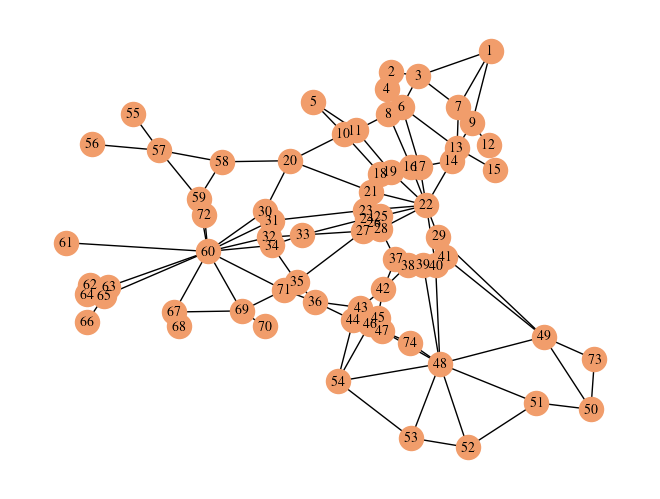

In [23]:
node_color = [cm.batlowS(4)]
plt.figure()
nx.draw(G_base, pos,
        horizontalalignment='center',
        verticalalignment='center',
        labels=numeric_node_labels,
        with_labels=True,
        font_size=10,
        font_color='black',
        node_color=(node_color if node_color is not None else 'lightgrey'),
        )

In [ ]:
def plot_network_my_style(
    G: nx.Graph,
    nodes_json: dict,
    figsize=(4, 3),
    node_color="lightgrey",
    edge_color="black",
    savefig=False,
    FIGURES_DIR=None,
    filename="ema_network.pdf",
    show=True,
):
    # style consistent with your snippet
    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.size"] = 16
    plt.rc("font", family="times")

    pos = _get_pos(G, nodes_json)

    # stable numeric labels 1..N
    node_order = sorted(G.nodes(), key=lambda x: str(x))
    numeric_labels = {n: str(i + 1) for i, n in enumerate(node_order)}

    plt.figure(figsize=figsize)
    nx.draw(
        G, pos,
        labels=numeric_labels, with_labels=True,
        node_color=node_color,
        edge_color=edge_color,
        horizontalalignment="center", verticalalignment="center",
    )

    if savefig:
        from pathlib import Path
        FIGURES_DIR = Path("figures") if FIGURES_DIR is None else Path(FIGURES_DIR)
        FIGURES_DIR.mkdir(parents=True, exist_ok=True)
        outpath = FIGURES_DIR / filename
        plt.savefig(outpath, bbox_inches="tight", dpi=300)
        print(f"Saved: {outpath}")

    if show:
        plt.show()
